,file,N,cos_ratio,cro_ratio,final_valid_loss
0,h8_N512_train_ratio_cos0.00_cro1.00.log,512,0.000,1.000,2.1507
1,h8_N512_train_ratio_cos0.50_cro0.50.log,512,0.500,0.500,2.1184
2,h8_N512_train_ratio_cos0.90_cro0.10.log,512,0.900,0.100,2.2684
3,h8_N512_train_ratio_cos0.95_cro0.05.log,512,0.950,0.050,2.4044
4,h8_N512_train_ratio_cos0.99_cro0.01.log,512,0.990,0.010,2.4117
5,h8_N512_train_ratio_cos0.995_cro0.005.log,512,0.995,0.005,2.7052
6,h8_N1024_train_ratio_cos0.00_cro1.00.log,1024,0.000,1.000,2.1053
7,h8_N1024_train_ratio_cos0.50_cro0.50.log,1024,0.500,0.500,2.0538
8,h8_N1024_train_ratio_cos0.90_cro0.10.log,1024,0.900,0.100,2.0598
9,h8_N1024_train_ratio_cos0.95_cro0.05.log,1024,0.950,0.050,2.1654


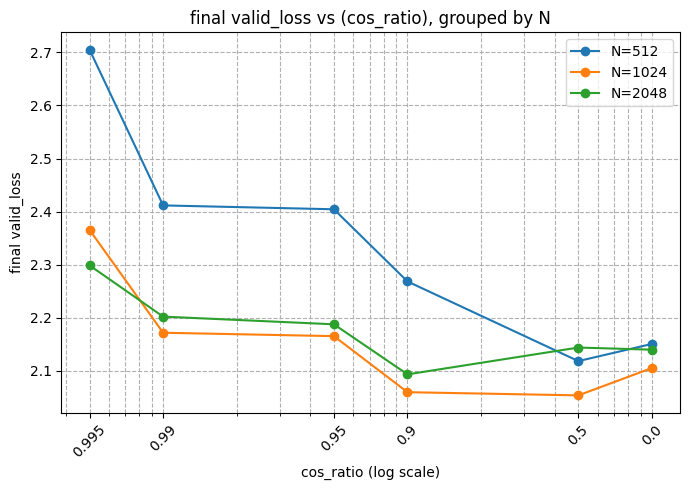

In [11]:
# =========================
# Step 0: 依赖
# =========================
import os
import re
from typing import Dict, List, Any, Tuple
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Step 1: 文件名生成层
# =========================
FLOAT_IN_NAME = r"[0-9]+(?:\.[0-9]+)?(?:e[-+]?[0-9]+)?"

def make_log_filename(N: int, cos_str: str, cro_str: str, prefix: str = "h8") -> str:
    """
    根据给定的 cos_str, cro_str（字符串形式）生成文件名
    """
    return f"{prefix}_N{N}_train_ratio_cos{cos_str}_cro{cro_str}.log"


def make_log_filenames(N_list, cos_list, cro_list, prefix="h8") -> List[str]:
    """
    批量生成 log 文件名
    cos_list, cro_list: 字符串列表，长度必须相等
    """
    if len(cos_list) != len(cro_list):
        raise ValueError("cos_list 和 cro_list 长度必须一致")
    filenames = []
    for N in N_list:
        for cos_str, cro_str in zip(cos_list, cro_list):
            filenames.append(make_log_filename(N, cos_str, cro_str, prefix))
    return filenames


def list_existing_logs(log_dir: str, candidates: List[str]) -> List[str]:
    return [os.path.join(log_dir, f) for f in candidates if os.path.exists(os.path.join(log_dir, f))]

# =========================
# Step 2: 解析引擎层（单文件）
# 仅解析，不绘图；输出 meta + series
# =========================
# 浮点数匹配（含科学计数）
FLOAT = r"[-+]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][-+]?\d+)?"

# 文件名解析
FNAME_RE = re.compile(
    rf"^(?P<prefix>\w+)_N(?P<N>\d+)_train_ratio_cos(?P<cos>{FLOAT_IN_NAME})_cro(?P<cro>{FLOAT_IN_NAME})\.log$"
)

# 行解析
# 示例：epoch   0 summary: train_cos_loss : 0.080205, train_cro_loss : 5.5894, ...
TRAIN_SUMMARY_RE = re.compile(r"^epoch\s+(\d+)\s+summary:\s+(.*)$")
TRAIN_KV_RE      = re.compile(rf"(\w+_loss)\s*:\s*({FLOAT})")

# 示例：epoch   0 summary: valid_cos_loss : 0.073170,
VALID_SUMMARY_RE = re.compile(r"^epoch\s+(\d+)\s+summary:\s+.*(valid_cos_loss)\s*:\s*(" + FLOAT + r")")
# 示例：valid loss: 5.9174, accuracy: 0.0195
VALID_LINE_RE    = re.compile(r"^valid loss:\s*(" + FLOAT + r")\b")

def parse_filename_meta(filename: str) -> Dict[str, Any]:
    m = FNAME_RE.match(filename)
    if not m:
        return {"file": filename, "N": None, "cos_ratio": None, "cro_ratio": None}
    N = int(m.group("N"))
    cos_ratio = float(m.group("cos"))
    cro_ratio = float(m.group("cro"))
    return {"file": filename, "N": N, "cos_ratio": cos_ratio, "cro_ratio": cro_ratio}

def parse_log_file(filepath: str) -> Dict[str, Any]:
    meta = parse_filename_meta(os.path.basename(filepath))
    series: Dict[str, List[float]] = {
        "train_cos_loss": [], "train_cro_loss": [], "train_tot_loss": [], "vocab_cos_loss": [],
        "valid_cos_loss": [], "valid_loss": []
    }
    epochs_train: List[int] = []
    epochs_valid: List[int] = []
    last_epoch_seen: int | None = None

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()

            # 训练 summary 行
            mt = TRAIN_SUMMARY_RE.match(line)
            if mt:
                ep = int(mt.group(1))
                last_epoch_seen = ep
                kv_part = mt.group(2)
                for k, v in TRAIN_KV_RE.findall(kv_part):
                    if k in series:
                        series[k].append(float(v))
                epochs_train.append(ep)
                continue

            # 验证 summary 行（valid_cos_loss）
            mv = VALID_SUMMARY_RE.match(line)
            if mv:
                ep_v = int(mv.group(1))
                last_epoch_seen = ep_v
                val_cos = float(mv.group(3))
                series["valid_cos_loss"].append(val_cos)
                epochs_valid.append(ep_v)
                continue

            # 验证 loss 行（整体 valid loss）
            ml = VALID_LINE_RE.match(line)
            if ml:
                vloss = float(ml.group(1))
                series["valid_loss"].append(vloss)
                # 无法可靠拿到 epoch 时，用 last_epoch_seen 做近似标记（可选）
                if last_epoch_seen is not None and (not epochs_valid or epochs_valid[-1] != last_epoch_seen):
                    epochs_valid.append(last_epoch_seen)

    return {"meta": meta, "series": series, "epochs_train": epochs_train, "epochs_valid": epochs_valid}

# =========================
# Step 3: 批量收集层
# =========================
def parse_multiple_logs(filepaths: List[str]) -> List[Dict[str, Any]]:
    runs = []
    for p in filepaths:
        try:
            runs.append(parse_log_file(p))
        except Exception as e:
            # 解析异常时保留最小信息，避免中断批处理
            runs.append({"meta": {"file": os.path.basename(p), "N": None, "cos_ratio": None, "cro_ratio": None},
                         "series": {}, "error": str(e)})
    return runs


# =========================
# Step 4: 聚合与特征派生层
# 产出绘图表（不读文件，不解析）
# =========================
def build_final_valid_table(runs: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    输出列：file, N, cos_ratio, cro_ratio, final_valid_loss
    若不存在 valid_loss，则设为 NaN
    """
    rows: List[Dict[str, Any]] = []
    for r in runs:
        meta = r.get("meta", {})
        ser  = r.get("series", {})
        vlist = ser.get("valid_loss", [])
        rows.append({
            "file": meta.get("file"),
            "N": meta.get("N"),
            "cos_ratio": meta.get("cos_ratio"),
            "cro_ratio": meta.get("cro_ratio"),
            "final_valid_loss": (vlist[-1] if vlist else float("nan"))
        })
    return pd.DataFrame(rows)

def build_epoch_table(runs: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    可选：构建按 epoch 展开的长表，方便后续画时序曲线。
    列：file, N, cos_ratio, cro_ratio, phase(train/valid), epoch, metric, value
    """
    recs: List[Dict[str, Any]] = []
    for r in runs:
        meta = r.get("meta", {})
        ser  = r.get("series", {})
        ep_tr = r.get("epochs_train", [])
        ep_va = r.get("epochs_valid", [])
        # 训练指标
        for name in ["train_cos_loss", "train_cro_loss", "train_tot_loss", "vocab_cos_loss"]:
            vals = ser.get(name, [])
            for i, v in enumerate(vals):
                ep = ep_tr[i] if i < len(ep_tr) else i
                recs.append({"file": meta.get("file"), "N": meta.get("N"),
                             "cos_ratio": meta.get("cos_ratio"), "cro_ratio": meta.get("cro_ratio"),
                             "phase": "train", "epoch": ep, "metric": name, "value": v})
        # 验证指标
        for name in ["valid_cos_loss", "valid_loss"]:
            vals = ser.get(name, [])
            for i, v in enumerate(vals):
                ep = ep_va[i] if i < len(ep_va) else i
                recs.append({"file": meta.get("file"), "N": meta.get("N"),
                             "cos_ratio": meta.get("cos_ratio"), "cro_ratio": meta.get("cro_ratio"),
                             "phase": "valid", "epoch": ep, "metric": name, "value": v})
    return pd.DataFrame(recs)

# =========================
# Step 5: 可视化层（仅消费表）
# =========================
def plot_valid_loss_by_one_minus_cos(df_final: pd.DataFrame):
    """
    横轴使用 1 - cos_ratio (log scale)，标签显示 cos_ratio
    """
    if df_final.empty:
        print("No data to plot.")
        return

    fig, ax = plt.subplots(figsize=(7, 5))

    for N, grp in df_final.groupby("N"):
        g = grp.dropna(subset=["final_valid_loss"]).sort_values("cos_ratio")
        if g.empty:
            continue
        x = 1.0 - g["cos_ratio"].astype(float)   # 差值
        ax.plot(x, g["final_valid_loss"], marker="o", label=f"N={N}")

    ax.set_xscale("log")
    ax.set_xlabel("cos_ratio (log scale)")
    ax.set_ylabel("final valid_loss")
    ax.set_title("final valid_loss vs (cos_ratio), grouped by N")

    # 用 cos_ratio 原值做标签
    xticks = 1.0 - df_final["cos_ratio"].dropna().unique().astype(float)
    xticks = sorted(xticks)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(1 - x) for x in xticks], rotation=45)

    ax.grid(True, which="both", ls="--")
    ax.legend()
    plt.tight_layout()
    plt.show()




# =========================
# Step 6: 示例（按需启用）
# =========================
log_dir = "."

N_list = [512, 1024, 2048]
cos_list = ["0.00", "0.50", "0.90", "0.95", "0.99", "0.995"]
cro_list = ["1.00", "0.50", "0.10", "0.05", "0.01", "0.005"]


candidates = make_log_filenames(N_list, cos_list, cro_list)
filepaths  = list_existing_logs(log_dir, candidates)
runs       = parse_multiple_logs(filepaths)

df_final   = build_final_valid_table(runs)
display(df_final.sort_values(["N", "cos_ratio"]))

plot_valid_loss_by_one_minus_cos(df_final)

